# Non linear analysis - Assignment 3

18.10.2023 - Jérémie Engler and Laure Toullier

# COPIE DE LA PARTIE B DE L'ASSIGNMENT 2

In this assignment, the material is considered linear (Young's modulus stays constant over time) and the geometry is non-linear (the length of each element varies over time).

In [1]:
#imports

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import math

np.set_printoptions(precision=5, suppress=True, linewidth=150)

Params = plt.rcParams
Params['figure.figsize'] = (14, 7) 

General data

In [2]:
#Geometric data for the truss:

n=3  #nb of nodes
DOF=2*n #degree of freedom

support=[0,2] #number of the nodes where there is a support
act_P=np.array([1])
rests=[1,1,0,0,1,1] #restraints 

a=3000 #mm
b=4000 #mm   
area=np.array([15000, 2000])

In [3]:
#Material 
E0 =np.array([200e3, 200e3])  # N/mm^2
E = E0.copy()
sigma_0=np.array([500, 500]) # N/mm^2
eps_0=sigma_0/E
print(eps_0)
alpha=0.02

[0.0025 0.0025]


In [4]:
#Load definition

load=10e6
P=np.zeros(DOF).reshape(n,2) 
theta_P=60 #°, inclination of the load regarding the x-axis

    #Application of the load at the corresponding nodes:

P[1]=[load*np.cos(np.radians(theta_P)),load*np.sin(np.radians(theta_P))]
print(P)

[[      0.            0.     ]
 [5000000.      8660254.03784]
 [      0.            0.     ]]


Definition of the geometry

In [5]:
#Generate the nodes of the truss and their location (if 1st node at (0,0))

nodes=np.zeros(n*2).reshape(n,2)

for i in range(n):
    nodes[i,0]=a*i
    if i%2==0:
        nodes[i,1]=0
    else:
        nodes[i,1]=b

print(nodes)

[[   0.    0.]
 [3000. 4000.]
 [6000.    0.]]


In [6]:
#Connectivity: connect nodes with bar element

connectivity=[]

for i in range(n):
    if i<(n-2):
        connectivity.append([i+1, i+2])
#        connectivity.append([i+1, i+3])
    if i==n-2:
        connectivity.append([i+1, i+2])
        
Connectivity=np.array(connectivity)

nb_members=int(np.size(Connectivity)/2)
    
print(Connectivity)

[[1 2]
 [2 3]]


In [7]:
#length and rotation matrix

def L_angle_T (nodes, Connectivity, nb_members):

   #angles and length
    angles=[]
    length=[]
    
    for i in range(nb_members):
        
        x1=nodes[Connectivity[i,0]-1,0]      #For each node at the extremity of each bar, we get its location in x and y.
        y1=nodes[Connectivity[i,0]-1,1]
        x2=nodes[Connectivity[i,1]-1,0]
        y2=nodes[Connectivity[i,1]-1,1]
        dx=x2-x1
        dy=y2-y1
        length.append(np.sqrt(dx**2+dy**2))
        
        if np.isclose(y1, y2):
            if np.isclose(x1, x2):
                angles.append(90)
            else:
                angles.append(0)
        else:
            theta=np.arcsin((y2-y1)/np.sqrt(dx**2+dy**2)) #calculate the angle between the x-axis and the bar element
            angles.append(math.degrees(theta))
       
    #Transformation matrix for each bar element of the truss
    c=[]
    s=[]
    for i in range(nb_members):
        c.append(np.cos(np.radians(angles[i])))
        s.append(np.sin(np.radians(angles[i])))
    
    T=np.zeros((nb_members,4,4))

    for i in range(nb_members):
        T[i,0,0]=c[i]
        T[i,0,1]=s[i]
        T[i,1,0]=-s[i]
        T[i,1,1]=c[i]
        T[i,2,2]=c[i]
        T[i,2,3]=s[i]
        T[i,3,2]=-s[i]
        T[i,3,3]=c[i]
    
    return length, angles, T

In [22]:
L, angles, T =L_angle_T (nodes, Connectivity, nb_members)
print(f'L={L}')
print(f'T={T}')
print(f"Angles = {angles}")

L=[5000.0, 5000.0]
T=[[[ 0.6  0.8  0.   0. ]
  [-0.8  0.6  0.   0. ]
  [ 0.   0.   0.6  0.8]
  [ 0.   0.  -0.8  0.6]]

 [[ 0.6 -0.8  0.   0. ]
  [ 0.8  0.6  0.   0. ]
  [ 0.   0.   0.6 -0.8]
  [ 0.   0.   0.8  0.6]]]
Angles = [53.13010235415599, -53.13010235415599]


Stiffness matrix

In [17]:
def stiffness (E0, area, nb_members, DOF, Connectivity, T, L, L0, angles):

    # Unit stiffness matrix of bar in local coordinate system
    K_unit = np.array([[1, 0, -1, 0], 
                   [0, 0,  0, 0], 
                   [-1, 0, 1, 0], 
                   [0, 0, 0, 0]])
    
    #local stiffness matrix for each bar
    k_local=[]
    k_t_local=[]
    
    for i in range(nb_members):
        k_local.append(E0[i]*area[i]/L[i]) 
        #k_t_local.append(E[i]*area[i]/L[i])
        
    #Material stiffness for each bar in global coordinates system
    k_global=[]
    #k_t_global=[]

    for i in range(nb_members):
        k=k_local[i] * T[i].T @ K_unit @ T[i] 
        #k_t=k_t_local[i]*T[i].T@K_unit@T[i] 
        k_global.append(k)
        #k_t_global.append(k_t)
    
    #Geometric stiffness for each bar in global coordinates system
    G=np.array([np.sin(a)**2, -np.sin(a)*np.cos(a), -np.sin(a)**2, np.sin(a)*np.cos(a),
                -np.sin(a)*np.cos(a), np.cos(a)**2, np.sin(a)*np.cos(a), -np.cos(a)**2,
                -np.sin(a)**2, np.sin(a)*np.cos(a), np.sin(a)**2, -np.sin(a)*np.cos(a),
                np.sin(a)*np.cos(a), -np.cos(a)**2, -np.sin(a)*np.cos(a), np.cos(a)**2])
    
    k_g_global=[]
    for i in range(nb_members):
        a=angles[i]
        k_g_global.append(k_local[i]*(L-L0)*G)


    #Stiffness in global system
    K_globalCS_bar=np.zeros((nb_members, DOF,DOF))
    K_global=np.zeros((DOF,DOF))
    k_global = np.array(k_global)

    K_g_global=np.zeros((nb_members,DOF,DOF))
    K_g_global_bar=np.zeros((DOF,DOF))
    k_g_global=np.array(k_g_global)
    
    for i, ((u, v), k) in enumerate(zip(Connectivity, k_global)):       
        #we build all the global material stiffness matrix for each bar in the entire system and sum them.
        K_global[2*u-2:2*u,2*u-2:2*u] += k[0:2, 0:2]
        K_global[2*u-2:2*u,2*v-2:2*v] += k[0:2, 2:4]
        K_global[2*v-2:2*v,2*u-2:2*u] += k[2:4, 0:2]
        K_global[2*v-2:2*v,2*v-2:2*v] += k[2:4, 2:4]
    
        #global material stiffness matrix for each bar in the entire system 
        K_globalCS_bar[i, 2*u-2:2*u,2*u-2:2*u] = k[0:2, 0:2]
        K_globalCS_bar[i, 2*u-2:2*u,2*v-2:2*v] = k[0:2, 2:4]
        K_globalCS_bar[i, 2*v-2:2*v,2*u-2:2*u] = k[2:4, 0:2]
        K_globalCS_bar[i, 2*v-2:2*v,2*v-2:2*v] = k[2:4, 2:4]
    
    for i, ((u, v), k) in enumerate(zip(Connectivity, k_g_global)):       
        #we build all the global geometric stiffness matrix for each bar in the entire system and sum them.
        K_g_global[2*u-2:2*u,2*u-2:2*u] += k[0:2, 0:2]
        K_g_global[2*u-2:2*u,2*v-2:2*v] += k[0:2, 2:4]
        K_g_global[2*v-2:2*v,2*u-2:2*u] += k[2:4, 0:2]
        K_g_global[2*v-2:2*v,2*v-2:2*v] += k[2:4, 2:4]

        #global geometric stiffness matrix for each bar in the entire system 
        K_g_global_bar[i, 2*u-2:2*u,2*u-2:2*u] = k[0:2, 0:2]
        K_g_global_bar[i, 2*u-2:2*u,2*v-2:2*v] = k[0:2, 2:4]
        K_g_global_bar[i, 2*v-2:2*v,2*u-2:2*u] = k[2:4, 0:2]
        K_g_global_bar[i, 2*v-2:2*v,2*v-2:2*v] = k[2:4, 2:4]

    K_tangent=K_global+K_g_global
           
    return (K_global,K_tangent)

Generate displacements

In [18]:
#Calculate the displacements of the nodes with a load applied

def displacement(support, act_P, P, K_global, DOF):

    F_red=np.zeros(DOF-2*len(support))

    for i in range(n):
        if i in act_P:
            F_red[i*2-2]=P[i,0]
            F_red[i*2-1]=P[i,1]  
        
    a=2*(n-len(support)) 
    K_red=np.zeros((a,a)) #reduced stiffness matrix for the nodes where there are displacements
    K_red=K_global[2:a+2, 2:a+2]

    u_red=np.linalg.inv(K_red)@F_red #reduced vector displacements for the nodes concerned by displacements

    u_vec=np.zeros(n*2) #global vector for displacements
    u_vec[2:n*2-2]=u_red[:]

    return(u_vec) 

Generate support reactions with the applied load

In [19]:
#Support reactions

def support_reactions (K_global, u_vec):
    F = K_global @ u_vec #N
    return(F)

Axial load in each element

In [20]:
#strain in each element

def strain (u, L, T, nb_members, Connectivity):

    u=u.reshape(3,2) #displacement at each node
    
    u_red=np.zeros((nb_members,4))
    u_red_loc=np.zeros((nb_members,4))
    strain=np.zeros(nb_members)

    for i in range(nb_members):
        index_1=Connectivity[i,0]
        index_2=Connectivity[i,1]
        u_red[i,:]=np.array([u[index_1-1,0], u[index_1-1, 1], u[index_2-1,0], u[index_2-1,1]]) #displacement in global coordinates for each bar
        u_red_loc[i,:]=T[i]@u_red[i,:] #displacement in local coordinates for each bar
        strain[i]=(u_red_loc[i,2]-u_red_loc[i,0])/L[i] #axial strain for each bar
    
    return u_red, u_red_loc, strain


In [24]:
#internal force for each displacement

def internal_force(Connectivity, area, L0, E0, u, L, T, sigma_0, eps_0, nb_members):    

    #internal force in each bar

    u_red, u_red_loc, eps=strain (u, L, T, nb_members, Connectivity)
    pr_local=np.zeros((nb_members,4))
    pr_global=np.zeros((nb_members, 4))
    pr=np.zeros((nb_members,DOF))
    Pr=np.zeros(DOF)

    for i in range(nb_members):
        #if np.abs(eps[i])>eps_0[i]:
            #E[i]=alpha*E0[i]
            #print(f"{E[i]=}  {E0[i]}  {alpha}")
            #a= (sigma_0[i]*area[i] + E[i]* area[i] * (np.abs(eps[i])-eps_0[i]))*np.sign(eps[i])
        mult = area[i]*E0[i]*(L[i]-L0[i])/L0[i]
        Vecteur = np.array([-np.cos(angles[i]), -np.sin(angles[i]), np.cos(angles[i]), np.sin(angles[i])])
        pr_global[i,:]=mult*Vecteur
       # else:
       #     E[i]=E0[i]
       #     a=E[i]*area[i]*np.abs(eps[i])*np.sign(eps[i])
       #     print(f"{E[i]=}  {area[i] = }  {eps[i] = }")

        #pr_local[i,0]=-a
        #pr_local[i,2]=a

        #pr_global[i,:]=T[i].T@pr_local[i,:]
        print(f"{pr_global = }")

        index_1=Connectivity[i,0] #value of 1st node of the bar
        index_2=Connectivity[i,1] #value of 2nd node of the bar
        pr[i,(index_1-1)*2] = pr_global[i,0]
        pr[i,(index_1)*2-1] = pr_global[i,1]
        pr[i,(index_2-1)*2] = pr_global[i,2]
        pr[i,index_2*2-1] = pr_global[i,3]   

    Pr=pr.sum(axis=0)
    print(f"{Pr = }")

    return Pr #Pr at node 2 in global coordinates (2*1)

internal_force(Connectivity, area, [5000,5000], E0,
               # np.array([0, 0, 16.2767, 220.0139, 0, 0]),
               np.array([0, 0, 0.0163, 0.9856, 0, 0]),
               L, T, sigma_0, eps_0, nb_members)

pr_global = array([[ 0., -0., -0.,  0.],
       [ 0.,  0.,  0.,  0.]])
pr_global = array([[ 0., -0., -0.,  0.],
       [ 0.,  0., -0., -0.]])
Pr = array([0., 0., 0., 0., 0., 0.])


array([0., 0., 0., 0., 0., 0.])

   1.0e+06 *

   -5.7476
   -7.6635
    5.0000
    8.6603
    0.7476
   -0.9968

Newton Raphson

In [16]:
#Initialisation

u=np.zeros((DOF)) #initial nodal displacement
du = np.zeros(DOF) #initialization of delta_u (no force, no displacement)
print(f'u0={u}')
L0, angles_0, T0 = L_angle_T(nodes, Connectivity, nb_members )
K_global, K_tangent= stiffness (E0, area, nb_members, DOF, Connectivity, T, L, L0, angles) #initial stiffness matrix
R=np.zeros((DOF))   
load_incr = 20 #increment for loadstep
iter_lim = 20
tol=np.max(area)*np.max(sigma_0)/1e5 #tolerance
print(f'K_0={K_global}')

u0=[0. 0. 0. 0. 0. 0.]


UnboundLocalError: cannot access local variable 'a' where it is not associated with a value

In [15]:
#Generalisation

steps = 1
lams =  np.linspace(1,load_incr)/load_incr
P_applied = np.zeros((load_incr, DOF))


#lists to generate later the graphs !
u1 = []
u2 = []
p1 = []
p2 = []
norm_r_print = []
iteration = []

iteration_counter = 0

#loops:
for i in range (load_incr):
    print(f"################# Nouvelle itération sur {i=} ######################")
    P_applied[i,:]=P.reshape((1,DOF))*(i+1)/load_incr
    print("P_applied", P_applied[i,:])

    print(f'delta_u={du}')
    p1.append(P_applied[i,2])
    p2.append(P_applied[i,3])

    for j in range(iter_lim):
        print(f"%%%%%%%%%%%%%% Nouvelle itération sur {j=} %%%%%%%%%%%%%%%%%")
        iteration_counter += 1

        #displacement:
        u=u+du
        print(f'u={u}')

        #new length calculated with the nodal displacements
        nodes=nodes+np.array(delta_u).reshape(3,2) #new global displacements 
        L, angles, T =L_angle_T (nodes, Connectivity, nb_members) #new length and new angle

        #internal force
        u_red, u_bar, eps=strain (u, L, T, nb_members, Connectivity)
        print(f'u_red={u_red}')
        print(f'u_bar={u_bar}')
        print(f'strain={eps}')
        Pr=internal_force(Connectivity, area, alpha, E0, u, L, T, sigma_0, eps_0, nb_members)

        #residual force
        R[2:4]=P_applied[i,2:4].reshape((1,2))-Pr[2:4]
        print(f'PR={Pr}')
        print(f'R={R}')
        norm_R=np.linalg.norm(R) 
        norm_r_print.append(norm_R)
        iteration.append(iteration_counter)

        #tangent stiffness
        K_global, K_tangent = stiffness (E0, area, nb_members, DOF, Connectivity, T, L, L0, angles) #new tangent stiffness matrix (K_global remains the same)
 
        if norm_R < tol:
            print(">>>>>>>>>>>>> norm_R < tol")
            u1.append(u[2])
            u2.append(u[3])
            break #if the tolerance is reached, we need to go "out of the loop" to go to the newt load iteration

        if norm_R>tol and j==iter_lim-1:
            raise ValueError("No convergence !")
        
        else:
            #Update the strain-increment delta_u in global coordinates:
            r=R.reshape((3,2))
            du=displacement(support, act_P, r, K_tangent, DOF)
            print(f'du={du}')

NameError: name 'load_incr' is not defined

Print

In [ ]:
def printgraph(x,y,xname,yname,unit1, unit2):
    plt.figure(figsize=(7, 5))
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')
    
    # Show a straight line
    plt.axline((x[0], y[0]), (x[1], y[1]))

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

[0.016276710966935774, 0.03255342193387155, 0.04883013290080732, 0.0651068438677431, 0.08138355483467888, 0.09766026580161466, 0.11393697676855044, 0.13021368773548622, 0.146490398702422, 0.16276710966935778, 0.17904382063629357, 0.19532053160322935, 0.21159724257016513, 0.2278739535371009, 0.2441506645040367, 11.384812459527614, 13.835204321894938, 14.649039870242063, 15.46287541858873, 16.276710966935468]
[250000.00000000006, 500000.0000000001, 750000.0000000002, 1000000.0000000002, 1250000.0000000002, 1500000.0000000005, 1750000.0000000005, 2000000.0000000005, 2250000.0000000005, 2500000.0000000005, 2750000.0000000005, 3000000.000000001, 3250000.000000001, 3500000.000000001, 3750000.000000001, 4000000.000000001, 4250000.000000001, 4500000.000000001, 4750000.000000001, 5000000.000000001]
[4000. 4000.]


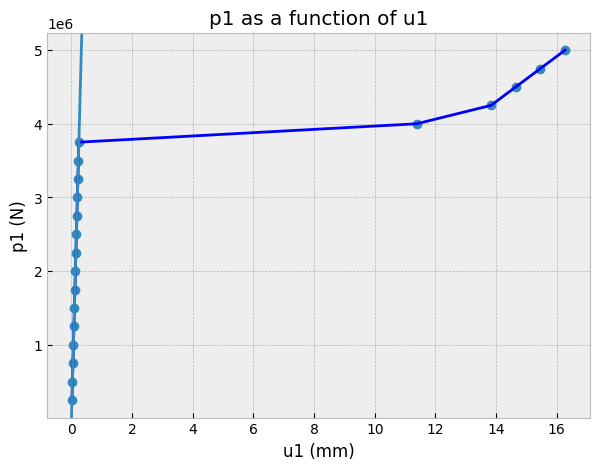

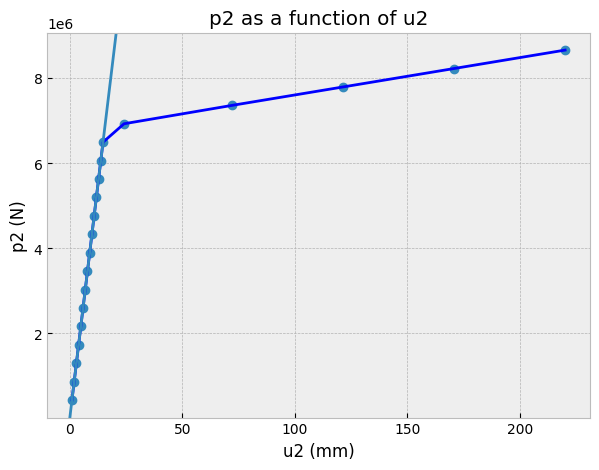

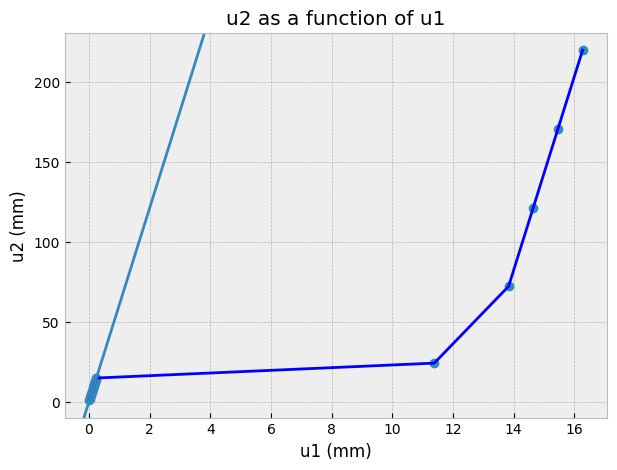

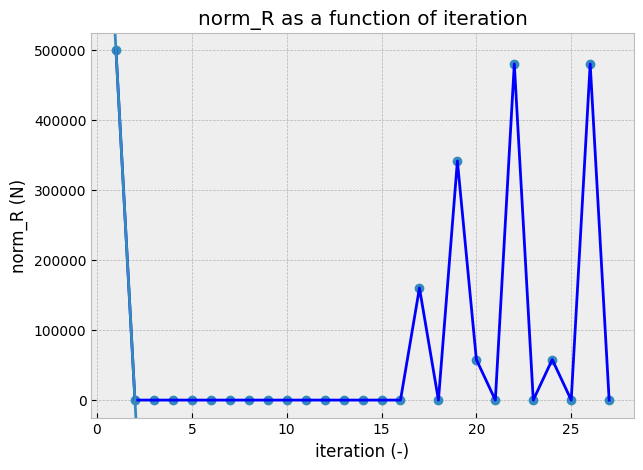

In [ ]:
print(u1)
print(p1)
print(E)
printgraph(u1,p1,"u1","p1","mm","N")
printgraph(u2,p2,"u2","p2","mm","N")
printgraph(u1,u2,"u1","u2","mm","mm")
printgraph(iteration,norm_r_print,"iteration","norm_R","-","N")